In [1]:
import serial
import struct
import time
import numpy as np
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from serial.tools.list_ports import comports

def read_number(msg):
    return int(input(msg))

def read_port(msg):
    port = input(msg)
    #index = input(msg)
    #port = "COM8";
    return serial.Serial(port, 9600)

            
def print_until_keyword(keyword, device):
    while True: 
        msg = device.serial.readline().decode()
        if msg[:-2] == keyword: break
        #else: print(f'({arduino.port}):',msg, end='')
            
def read_matrix(device, dimms):
    result = np.zeros((1,dimms)).reshape(-1)
    for i in range(dimms):
        device.serial.read()
        result[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return result.reshape(dimms)

clear = lambda: os.system('clear')

2023-11-12 16:42:06.369338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Device:
    def __init__(self, serial):
        self.serial = serial
        self.weights = []
        self.metalayers = []
        self.gradients = []
        
    def set_weights(self, weights):
        self.weights = weight
        
    def set_metadata(self, metalayer):
        self.metalayer = metalayer
        
def getDevices():
    num_devices = read_number("Number of devices: ")
    # num_devices = 2
    #num_devices=3

    available_ports = comports()
    print("Available ports:")
    for available_port in available_ports: print(available_port)

    time.sleep(1)
    devices = [read_port(f"Port device_{i+1}: ") for i in range(num_devices)]
    #devices= [serial.Serial(port, 9600) for port in ['/dev/cu.usbmodem14101', '/dev/cu.usbmodem14201','/dev/cu.usbmodem14301']]
    list_devices = []
    for device in devices:
        list_devices.append(Device(device))
    return list_devices

class Layer:
    def __init__(self, layer_type):
        self.layer_type = layer_type
        
    def __repr__(self):
        return f"{self.layer_type}"
    
class Dense(Layer):
    def __init__(self, rows, cols):
        super().__init__("Dense")
        self.rows = rows
        self.cols = cols
        
    def __repr__(self):
        return f"{self.layer_type=} {self.rows=} {self.cols=}"
    
class MaxPooling(Layer):
    def __init__(self, r, c, ch):
        super().__init__("MaxPooling")
        self.rows = r
        self.cols = c
        self.ch = ch
        
    def __repr__(self):
        return f"{self.layer_type}  - {self.rows=} {self.cols=} {self.ch=}"
    
class Conv2D(Layer):
    def __init__(self, kh, kw, c, kc):
        super().__init__("Conv2D")
        self.kh = kh
        self.kw = kw
        self.c = c
        self.kc = kc
        
    def __repr__(self):
        return f"{self.layer_type=} - {self.kh=} {self.kw=} {self.c=} {self.kc=}"
        

In [3]:
def receive_model_info(device):
    device.serial.reset_input_buffer()
    device.serial.write(b's')
    print_until_keyword('start', device) # CLEAN SERIAL
    
    bytesToRead = device.serial.read(1).decode()
    time.sleep(1)
    if bytesToRead == 'i':
        device.serial.write(struct.pack('f', LEARNING_RATE))
        [num_layers] = struct.unpack('i', device.serial.read(4))
        layers = []
        for i in range(num_layers):
            [layer_type] = struct.unpack('i', device.serial.read(4))
            if layer_type == -1:
                [rows, cols] = struct.unpack('ii', device.serial.read(8))
                layers.append(Dense(rows, cols))
            elif layer_type == -2:
                [rows, cols, ch] = struct.unpack('iii', device.serial.read(12))
                layers.append(MaxPooling(rows,cols,ch))
            elif layer_type == -3:
                [kh, kw, c, kc] = struct.unpack('iiii', device.serial.read(16))
                layers.append(Conv2D(kh,kw,c,kc))
            # dimms.append((1,cols)) # bias
            # dimms.append((rows,cols)) # matrix weigths
        device.metalayers = layers
    return num_layers, layers


In [4]:
import random    
## RECEIVE MODEL WEIGHT
def get_device_weights(device, bias_dimm, w_dimm):
    number_of_floats = w_dimm[0] * w_dimm[1]
    weights = np.zeros(w_dimm).reshape(-1)
    for i in range(number_of_floats):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
        
    number_of_floats = bias_dimm[0] * bias_dimm[1]
    bias = np.zeros(bias_dimm).reshape(-1)
    for i in range(number_of_floats):
        device.serial.read()
        bias[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape(w_dimm), bias.reshape(bias_dimm)
    
def get_device_weights_cnn(device, kh, kw, c, kc):
    in_size = kh * kw * c
    out_size = kh * kw * kc
    weights = np.zeros((kh, kw, c, kc)).reshape(-1)
    for i,w in enumerate(weights.reshape(-1)):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
            
    bias = np.zeros((1,kc)).reshape(-1)
    for i,b in enumerate(bias.reshape(-1)):
        device.serial.read()
        bias[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape((kh, kw, c, kc)), bias.reshape((1,kc))

def get_device_weights_pool(device, rows, cols, ch):
    weights = np.random.randn(rows, cols, ch).reshape(-1)
    for i,w in enumerate(weights.reshape(-1)):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape((rows, cols, ch))
    

In [5]:
def initialize_device_weights(device, bias_dimm, w_dimm):
    np.random.seed(42)
    random.seed(42)
    bias = np.zeros(bias_dimm)
    weights = np.random.randn(w_dimm[0], w_dimm[1]) * np.sqrt(6.0 / (w_dimm[0] + w_dimm[1]))
    return weights, bias
    device.serial.write(struct.pack('f'*bias.reshape(-1).shape[0], *bias.reshape(-1)))

    #for w in weights.reshape(-1):
    #   data = device.serial.read()
    device.serial.write(struct.pack('f'*weights.reshape(-1).shape[0], *weights.reshape(-1)))
    
def initialize_device_weights_cnn(device, kh, kw, c, kc):
    np.random.seed(42)
    random.seed(42)
    bias = np.zeros((1,kc))
    in_size = kh * kw * c
    out_size = kh * kw * kc
    weights = np.random.randn(kh, kw, c, kc) * np.sqrt(6.0 / (in_size + out_size))
    return weights, bias
    print(f"Sending weights for layer Conv2D")
    #for b in bias.reshape(-1):
        #data = device.serial.read()
    device.serial.write(struct.pack('f'* bias.reshape(-1).shape[0], *bias.reshape(-1)))

    #for w in weights.reshape(-1):
    #   data = device.serial.read()
    device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))

def create_initial_model(device, layers):
    weights = []
    for layer in layers:
        if layer.layer_type == "Conv2D":
            weights.append(initialize_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc))
        elif layer.layer_type == "Dense":
            weights.append(initialize_device_weights(device, (1,layer.cols), (layer.rows,layer.cols)))
        else:
            weights.append((np.array([]), np.array([])))
    return weights

    
def send_initial_weights(device, global_model):
    for weights, bias in global_model:
        #print(weights.shape, bias.shape)
        device.serial.write(struct.pack('f' * bias.reshape(-1).shape[0], *bias.reshape(-1)))
        device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))
    

In [6]:
def send_weights(device, weights, layer):
    bias = weights[1]
    weights = weights[0]
    #print(f"Sending bias for Dense {bias.reshape(-1).shape} {device.serial.port}")
    #for b in bias.reshape(-1):
        #data = device.serial.read()
        #device.serial.write(struct.pack('f', b))
    if layer.layer_type != 'MaxPooling':
        device.serial.write(struct.pack('f' * bias.reshape(-1).shape[0],*bias.reshape(-1)))
        device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))

    #print(f"Sending weights for Dense {weights.reshape(-1).shape} {device.serial.port}")
    #for w in weights.reshape(-1):
        #data = device.serial.read()
        
def send_model_weights(device, weights):
    layers = device.metalayers
    device.serial.write(b'r')
 
    for i, layer in enumerate(weights):
        send_weights(device, weights[i], layers[i])

    #print(f"{device.serial.port} weights initialized!")

In [7]:
def get_model_weights(device):
    layers = device.metalayers
    device.serial.write(b'g') # Python --> ACK --> Arduino
    device.weights = []

    for i, layer in enumerate(layers):
        if layer.layer_type == "Conv2D":
            weights, biases = get_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc)
            device.weights.append((weights, biases))
        elif layer.layer_type == "Dense":
            weights, biases = get_device_weights(device, (1,layer.cols), (layer.rows,layer.cols))
            device.weights.append((weights, biases))
        elif layer.layer_type == "MaxPooling":
            #weights = get_device_weights_pool(device, layer.rows,layer.cols, layer.ch)
            device.weights.append((weights, np.array([])))
    #print(f"Model weight received!")

    
def get_model_gradients(device):
    layers = device.metalayers
    device.serial.write(b'g') # Python --> ACK --> Arduino
    device.gradients = []
    
    for i, layer in enumerate(layers):
        if layer.layer_type == "Conv2D":
            weights, biases = get_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc)
            device.gradients.append((weights, biases))
        elif layer.layer_type == "Dense":
            weights, biases = get_device_weights(device, (1,layer.cols), (layer.rows,layer.cols))
            device.gradients.append((weights, biases))
        elif layer.layer_type == "MaxPooling":
            #weights = get_device_weights_pool(device, layer.rows,layer.cols, layer.ch)
            device.gradients.append((np.array([]), np.array([])))
    #print(f"Model weight received!")


In [8]:
def send_sample(device, X, y=None):
    #if IS_KEYWORD_SPOTTING:
        #for i,k in enumerate(X.reshape(-1)):
            #device.serial.write(struct.pack('f',k))
            #print("SENT XX",i)
        #device.serial.write(struct.pack('h' * X.reshape(-1).shape[0], *X.reshape(-1)))
    #else:
    device.serial.write(struct.pack('f' * X.reshape(-1).shape[0], *X.reshape(-1)))

        #for i,k in enumerate(X.reshape(-1)):
            #raw = device.serial.read(4)
            #j = struct.unpack('i', raw)[0]
            #device.serial.write(struct.pack('f',k))
            #print("SENT",j, i)
            #print(f"returned error = {raw}")

    #print(f"Want to send y={y.shape}")
    if y is not None:
        device.serial.write(struct.pack('f' * y.reshape(-1).shape[0], *y.reshape(-1)))
        #for i, t in enumerate(y.reshape(-1)):
            #device.serial.read()
            #device.serial.write(struct.pack('f', t))
        #print(f"Sample y = {y.shape} sent!")

def get_tick():
    return time.time_ns()

def train_single(device, x, y, train_data):
    device.serial.write(b"t")
    send_sample(device, x, y.reshape(1,TARGET_SIZE))
    start = get_tick()
    output = read_matrix(device, TARGET_SIZE+1)
    end = get_tick()
    train_data['losses'][device.serial.port] = output[-1]
    train_data['times'][device.serial.port] = end-start
    res = output[:-1]
    train_data['acc'][device.serial.port] = 1 if np.argmax(y) == np.argmax(res) else 0


def train(device, X, y, size=1):
    error = 0.0
    for i in range(size):
        if i%100 == 0:
            print(f"{i}/{size} Done")
        device.serial.write(b"t")
        send_sample(device, X[i], y[i].reshape(1,TARGET_SIZE))
        #print("SAMPLE SENT")

        start = get_tick()
        output = read_matrix(device, TARGET_SIZE+1)
        #n_error = device.serial.read(4)
        #print(f"returned error = {n_error}")
        end = get_tick()
        loss = struct.unpack('f', n_error)[0]
        error += loss
    return end-start, error/size

def predict(device, X, y):
    device.serial.write(b"p")
    send_sample(device, X, y.reshape(1,TARGET_SIZE))
    # read last layer size output
    # Target size + 1 for the loss value
    start = get_tick()
    output = read_matrix(device, TARGET_SIZE+1)
    return get_tick() - start, output[:-1], output[-1]


- call getDevices() to obtain all conected devices
- asks the user how many devices you want to use
- send the initial model for every device
- create thread for every device
    - send samples and start training for one epoch
- wait for all threads to finish
- FEDERATED LEARNING
- create thread for every device and receive models
- permute the average of every layer
- create thread for every device and receive models
- send back the models

In [9]:
final_weights = []
def fl(devices):
    global final_weights
    
    # RECEIVE MODELS
    #print("Receiving models from devices...")
    threads = []
    for device in devices:
        thread = threading.Thread(target=get_model_weights, args=(device,))
        thread.daemon = True
        thread.start()
        threads.append(thread)

    for thread in threads: thread.join() # Wait for all the threads to end
    #print("Models received")
    # AVERAGE MODELS
    num_layers = len(devices[0].metalayers)
    assert num_layers > 0, "NO LAYERS!"

    #accuracies = fl_info_infer[-2]['accuracy']
    #total_accuracy = sum(accuracies.values())
    #normalized_accuracies = [accuracy / total_accuracy for accuracy in accuracies.values()]
    #print(normalized_accuracies)
    list_weights = []
    for i in range(num_layers):
        weights = np.array([device.weights[i][0] for device in devices])
        bias = np.array([device.weights[i][1] for device in devices])

        weights_avg = np.mean(weights, axis=0)
        bias_avg = np.mean(bias, axis=0)

        list_weights.append((weights_avg, bias_avg))
    #print("Average performed")
    # send model
    threads = []
    for device in devices:
        thread = threading.Thread(target=send_model_weights, args=(device, list_weights))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end
        
    final_weights = list_weights

In [10]:
def fl_sgd(devices):
    # RECEIVE MODELS
    threads = []
    for device in devices:
        thread = threading.Thread(target=get_model_gradients, args=(device,))
        thread.daemon = True
        thread.start()
        threads.append(thread)

    for thread in threads: thread.join() # Wait for all the threads to end
    #print("Models received")
    # AVERAGE MODELS
    num_layers = len(devices[0].metalayers)
    assert num_layers > 0, "NO LAYERS!"
    
    # GET GRADIENTS OF THE DEVICES
    list_weights = []
    for i in range(num_layers):
        gradients_w, gradients_b = devices[0].gradients[i]
        gradients_w = np.zeros_like(gradients_w)
        gradients_b = np.zeros_like(gradients_b)
        for k,device in enumerate(devices):
            #print(device.gradients[i][0])
            #print(device.gradients[i][1])
            gradients_w += device.gradients[i][0]
            gradients_b += device.gradients[i][1]
        
        list_weights.append((gradients_w,gradients_b))

    # SGD HERE
    for i, layer in enumerate(devices[0].metalayers):
        print("FF",list_weights[i][0], list_weights[i][1])
        if layer.layer_type == "MaxPooling":
            continue
        dw = iglobal_model[i][0] - list_weights[i][0] * 0.01
        db = iglobal_model[i][1] - list_weights[i][1] * 0.01
        
        iglobal_model[i] = (dw, db)
    
    
    # send model
    threads = []
    for device in devices:
        thread = threading.Thread(target=send_model_weights, args=(device, iglobal_model))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end



In [11]:
def train_device(device, X_train, Y_train,  info, steps = 1):
    device_losses = []
    device_times = []
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    
    if not isinstance(Y_train, np.ndarray):
        Y_train = np.array(Y_train)
    
    dt, loss = train(device, np.array(X_train).astype(np.int16), Y_train, steps)
    device_losses.append(loss)
    device_times.append(dt)
        
    info['losses'][device.serial.port] = device_losses
    info['train_time'][device.serial.port] = device_times

In [12]:
def predict_device(device, X, Y_test, info):
    device_times = []
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    acc = 0.0
    total_loss = 0.0
    df_time = 0
    for i, x in enumerate(X):
        if i%100 == 0:
            print(f"{device.serial.port} => [{i}/{X.shape[0]}] Done")
        
        dt, res, loss = predict(device, x, Y_test[i])
        acc += 1 if np.argmax(Y_test[i]) == np.argmax(res) else 0
        df_time += dt
        total_loss += loss
    info['accuracy'][device.serial.port] = acc/X.shape[0]
    info['infer_time'][device.serial.port] = df_time / X.shape[0]
    info['losses'][device.serial.port] = total_loss/X.shape[0]
    #info['res'][device.serial.port] = res


In [17]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import json

def get_anomaly():
    np.random.seed(42)
    random.seed(42)
    # Read the JSON file
    with open("datasets_2/stateMonitors.json", "r") as file:
        data = json.load(file)

    # Normalize the JSON data
    df = pd.json_normalize(data, max_level=20)
    df['anomaly'] = 0

    # Specify the size of the random subset
    subset_size = 200  # Replace with the desired subset size

    # Get a random subset of the DataFrame
    random_subset = df.sample(n=subset_size, random_state=42)  # Replace '42' with your desired random seed

    cols_to_rand = ['payload.messageSize','payload.state.QR','payload.state.QS','payload.state.QRU','payload.state.QWRP','payload.state.RT','payload.state.packetHeader.Size']
    for col in cols_to_rand:
        random_subset[col] += np.random.randint(2000)

    random_subset['anomaly'] = 1
    
    return df, random_subset

In [18]:
def reset_device(device):
    device.serial.write(b'f')

In [19]:
import threading
import time
devices = []
LEARNING_RATE = 0.001
TARGET_SIZE = 10
IS_KEYWORD_SPOTTING = False
def initialize_devices(lr = 0.001, target_size = 10, first=True):
    global devices
    global LEARNING_RATE
    global TARGET_SIZE
    
    TARGET_SIZE = target_size
    LEARNING_RATE = lr
    if first:
        devices = getDevices()
    else:
        threads = []
        for device in devices:
            print(f"RESETING DEVICE {device.serial.port}")
            thread = threading.Thread(target=reset_device, args=(device, ))
            thread.daemon = True
            threads.append(thread)

          # Start all the threads
        for thread in threads:
            thread.start()

        # Wait for all the threads to finish
        for thread in threads:
            thread.join()
        
    number_devices = 3
    
    time.sleep(3)
    
    threads = []
    for i, d in enumerate(devices):
        print(f"Receiving model info {i}")
        thread = threading.Thread(target=receive_model_info, args=(d, ))
        thread.daemon = True
        threads.append(thread)

      # Start all the threads
    for thread in threads:
        thread.start()

    # Wait for all the threads to finish
    for thread in threads:
        thread.join()

    iglobal_model = create_initial_model(devices[0], devices[0].metalayers)

    threads = []
    for i, d in enumerate(devices):
        print(f"Sending blank model for device {i}")
        thread = threading.Thread(target=send_initial_weights, args=(d, iglobal_model ))
        thread.daemon = True
        threads.append(thread)

      # Start all the threads
    for thread in threads:
        thread.start()

    # Wait for all the threads to finish
    for thread in threads:
        thread.join()
    print("All devices were initialized!")

## Anomaly Detection FL training

In [21]:
threshold = 0.01
X, anomalies = get_anomaly()
y = X['anomaly']
df = X.drop(['date','anomaly'], axis=1)
y_anomalies = anomalies['anomaly']
anomalies = anomalies.drop(['date','anomaly'], axis=1)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Create a StandardScaler object
scaler = MinMaxScaler()

# Apply z-score normalization to the DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# Create a StandardScaler object
scaler2 = MinMaxScaler()

# Fit the scaler on the training data
scaler2.fit(df)

# Apply the same normalization to the test data
df_test_normalized = pd.DataFrame(scaler2.transform(anomalies), columns=anomalies.columns)
df_test_normalized.head()

df_test_normalized = pd.concat([df_normalized, df_test_normalized])
df_test_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2505 entries, 0 to 199
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   payload.appPortDst                2505 non-null   float64
 1   payload.appPortSrc                2505 non-null   float64
 2   payload.messageId                 2505 non-null   float64
 3   payload.addrSrc                   2505 non-null   float64
 4   payload.addrDst                   2505 non-null   float64
 5   payload.messageSize               2505 non-null   float64
 6   payload.simCommand                2505 non-null   float64
 7   payload.state.Id                  2505 non-null   float64
 8   payload.state.Type                2505 non-null   float64
 9   payload.state.QR                  2505 non-null   float64
 10  payload.state.QS                  2505 non-null   float64
 11  payload.state.QRU                 2505 non-null   float64
 12  payload

In [22]:
import pickle 
def train_ae_with_fl(df, num_devices=3, fl_samples=5, lr=0.001, first=True, iid=True):
    initialize_devices(lr=lr, target_size=25, first=first)
    fl_rounds = 0
    
    X_Train = []
    total_entries = 2305
    each_split_size = total_entries // 3

    X_Train.append(df_normalized.values[0:each_split_size])
    X_Train.append(df_normalized.values[each_split_size:each_split_size*2])
    X_Train.append(df_normalized.values[each_split_size*2:each_split_size*3])

    training_data = []
    total_acc = {'/dev/cu.usbmodem13201':0, '/dev/cu.usbmodem13101':0, '/dev/cu.usbmodem13301':0}
    for i in range(each_split_size):
        if i%fl_samples==0 and i>0:
            fl(devices)
            fl_rounds += 1
        train_data = {'losses':{}, 'times':{}, 'acc':{}}
        threads = []
        for j, device in enumerate(devices):
            thread = threading.Thread(target=train_single, args=(device, X_Train[j][i],X_Train[j][i], train_data))
            thread.daemon = True
            thread.start()
            threads.append(thread)
        for thread in threads: thread.join() # Wait for all the threads to end
        training_data.append(train_data)
        print(f"Loss: {train_data['losses']} {i}/{each_split_size}")

    # SET THE DEVICES WEIGHT AS THE GLOBAL MODEL
    fl(devices)
    return training_data

In [23]:
loaded_dict = train_ae_with_fl(df,num_devices=3, fl_samples=25, lr=0.01, first=True, iid=True)

Number of devices: 3
Available ports:
/dev/cu.wlan-debug - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbmodem114301 - Envie M7
/dev/cu.usbmodem114201 - Envie M7
/dev/cu.usbmodem114101 - Envie M7
Port device_1: /dev/cu.usbmodem114301
Port device_2: /dev/cu.usbmodem114201
Port device_3: /dev/cu.usbmodem114101
Receiving model info 0
Receiving model info 1
Receiving model info 2
Sending blank model for device 0
Sending blank model for device 1
Sending blank model for device 2
All devices were initialized!
Loss: {'/dev/cu.usbmodem114301': 0.5459439158439636, '/dev/cu.usbmodem114201': 0.5078995823860168, '/dev/cu.usbmodem114101': 0.49548405408859253} 0/768
Loss: {'/dev/cu.usbmodem114301': 0.546226978302002, '/dev/cu.usbmodem114101': 0.486730694770813, '/dev/cu.usbmodem114201': 0.4873080849647522} 1/768
Loss: {'/dev/cu.usbmodem114301': 0.6005211472511292, '/dev/cu.usbmodem114101': 0.3937678635120392, '/dev/cu.usbmodem114201': 0.4373478293418884} 2/768
Loss: {'/dev/cu.usbmodem114301': 

Loss: {'/dev/cu.usbmodem114301': 0.0750788152217865, '/dev/cu.usbmodem114101': 0.04537181928753853, '/dev/cu.usbmodem114201': 0.06723780184984207} 54/768
Loss: {'/dev/cu.usbmodem114201': 0.2415306717157364, '/dev/cu.usbmodem114301': 0.2388862818479538, '/dev/cu.usbmodem114101': 0.11142948269844055} 55/768
Loss: {'/dev/cu.usbmodem114201': 0.05842022970318794, '/dev/cu.usbmodem114301': 0.036067232489585876, '/dev/cu.usbmodem114101': 0.17857426404953003} 56/768
Loss: {'/dev/cu.usbmodem114101': 0.1361546665430069, '/dev/cu.usbmodem114201': 0.08285032212734222, '/dev/cu.usbmodem114301': 0.22021716833114624} 57/768
Loss: {'/dev/cu.usbmodem114201': 0.08104605972766876, '/dev/cu.usbmodem114101': 0.16871628165245056, '/dev/cu.usbmodem114301': 0.1336073875427246} 58/768
Loss: {'/dev/cu.usbmodem114201': 0.0667395144701004, '/dev/cu.usbmodem114301': 0.18987677991390228, '/dev/cu.usbmodem114101': 0.08697278797626495} 59/768
Loss: {'/dev/cu.usbmodem114301': 0.03607210889458656, '/dev/cu.usbmodem1141

Loss: {'/dev/cu.usbmodem114301': 0.032633863389492035, '/dev/cu.usbmodem114101': 0.09166674315929413, '/dev/cu.usbmodem114201': 0.06986688077449799} 128/768
Loss: {'/dev/cu.usbmodem114101': 0.039771467447280884, '/dev/cu.usbmodem114301': 0.02890879474580288, '/dev/cu.usbmodem114201': 0.042335402220487595} 129/768
Loss: {'/dev/cu.usbmodem114201': 0.0558265745639801, '/dev/cu.usbmodem114301': 0.021539662033319473, '/dev/cu.usbmodem114101': 0.05820293724536896} 130/768
Loss: {'/dev/cu.usbmodem114301': 0.015445909462869167, '/dev/cu.usbmodem114201': 0.048054084181785583, '/dev/cu.usbmodem114101': 0.04613662138581276} 131/768
Loss: {'/dev/cu.usbmodem114301': 0.06542475521564484, '/dev/cu.usbmodem114101': 0.03857854753732681, '/dev/cu.usbmodem114201': 0.050993259996175766} 132/768
Loss: {'/dev/cu.usbmodem114201': 0.05581997334957123, '/dev/cu.usbmodem114301': 0.018508203327655792, '/dev/cu.usbmodem114101': 0.04296822100877762} 133/768
Loss: {'/dev/cu.usbmodem114301': 0.031118186190724373, '/

Loss: {'/dev/cu.usbmodem114201': 0.10018270462751389, '/dev/cu.usbmodem114101': 0.1201183870434761, '/dev/cu.usbmodem114301': 0.03536757081747055} 200/768
Loss: {'/dev/cu.usbmodem114301': 0.045713651925325394, '/dev/cu.usbmodem114101': 0.057071615010499954, '/dev/cu.usbmodem114201': 0.1443173736333847} 201/768
Loss: {'/dev/cu.usbmodem114301': 0.029250552877783775, '/dev/cu.usbmodem114201': 0.08757281303405762, '/dev/cu.usbmodem114101': 0.10678356140851974} 202/768
Loss: {'/dev/cu.usbmodem114301': 0.1042373776435852, '/dev/cu.usbmodem114101': 0.026814239099621773, '/dev/cu.usbmodem114201': 0.11627829819917679} 203/768
Loss: {'/dev/cu.usbmodem114301': 0.06835993379354477, '/dev/cu.usbmodem114201': 0.06515781581401825, '/dev/cu.usbmodem114101': 0.1798131912946701} 204/768
Loss: {'/dev/cu.usbmodem114201': 0.09567686170339584, '/dev/cu.usbmodem114301': 0.06335568428039551, '/dev/cu.usbmodem114101': 0.026132633909583092} 205/768
Loss: {'/dev/cu.usbmodem114201': 0.01800002157688141, '/dev/cu.

Loss: {'/dev/cu.usbmodem114101': 0.04606850445270538, '/dev/cu.usbmodem114301': 0.08781049400568008, '/dev/cu.usbmodem114201': 0.01587369106709957} 275/768
Loss: {'/dev/cu.usbmodem114101': 0.03101944364607334, '/dev/cu.usbmodem114301': 0.041328392922878265, '/dev/cu.usbmodem114201': 0.05192140117287636} 276/768
Loss: {'/dev/cu.usbmodem114301': 0.028384778648614883, '/dev/cu.usbmodem114101': 0.03516336530447006, '/dev/cu.usbmodem114201': 0.014654912054538727} 277/768
Loss: {'/dev/cu.usbmodem114301': 0.01829630881547928, '/dev/cu.usbmodem114201': 0.057429444044828415, '/dev/cu.usbmodem114101': 0.01542831864207983} 278/768
Loss: {'/dev/cu.usbmodem114101': 0.042675603181123734, '/dev/cu.usbmodem114301': 0.044485852122306824, '/dev/cu.usbmodem114201': 0.016007108613848686} 279/768
Loss: {'/dev/cu.usbmodem114301': 0.03675409033894539, '/dev/cu.usbmodem114201': 0.03873840719461441, '/dev/cu.usbmodem114101': 0.013491400517523289} 280/768
Loss: {'/dev/cu.usbmodem114301': 0.02054809033870697, '/

Loss: {'/dev/cu.usbmodem114101': 0.03806481137871742, '/dev/cu.usbmodem114201': 0.01709781587123871, '/dev/cu.usbmodem114301': 0.017467938363552094} 350/768
Loss: {'/dev/cu.usbmodem114301': 0.039212148636579514, '/dev/cu.usbmodem114201': 0.08813725411891937, '/dev/cu.usbmodem114101': 0.040159691125154495} 351/768
Loss: {'/dev/cu.usbmodem114301': 0.048143982887268066, '/dev/cu.usbmodem114101': 0.038445163518190384, '/dev/cu.usbmodem114201': 0.017224088311195374} 352/768
Loss: {'/dev/cu.usbmodem114201': 0.010280885733664036, '/dev/cu.usbmodem114101': 0.03616270050406456, '/dev/cu.usbmodem114301': 0.035704903304576874} 353/768
Loss: {'/dev/cu.usbmodem114301': 0.021809851750731468, '/dev/cu.usbmodem114201': 0.01832297444343567, '/dev/cu.usbmodem114101': 0.03344751521945} 354/768
Loss: {'/dev/cu.usbmodem114101': 0.030441489070653915, '/dev/cu.usbmodem114301': 0.045085515826940536, '/dev/cu.usbmodem114201': 0.011750292964279652} 355/768
Loss: {'/dev/cu.usbmodem114301': 0.028077680617570877, 

Loss: {'/dev/cu.usbmodem114301': 0.030882906168699265, '/dev/cu.usbmodem114101': 0.13450348377227783, '/dev/cu.usbmodem114201': 0.013928976841270924} 425/768
Loss: {'/dev/cu.usbmodem114301': 0.0362875759601593, '/dev/cu.usbmodem114101': 0.14953498542308807, '/dev/cu.usbmodem114201': 0.022851450368762016} 426/768
Loss: {'/dev/cu.usbmodem114301': 0.02486491948366165, '/dev/cu.usbmodem114101': 0.0954187661409378, '/dev/cu.usbmodem114201': 0.01757853291928768} 427/768
Loss: {'/dev/cu.usbmodem114201': 0.019374027848243713, '/dev/cu.usbmodem114101': 0.08797825127840042, '/dev/cu.usbmodem114301': 0.02293611504137516} 428/768
Loss: {'/dev/cu.usbmodem114301': 0.021709615364670753, '/dev/cu.usbmodem114201': 0.016154009848833084, '/dev/cu.usbmodem114101': 0.07805003970861435} 429/768
Loss: {'/dev/cu.usbmodem114301': 0.06334766745567322, '/dev/cu.usbmodem114101': 0.06899062544107437, '/dev/cu.usbmodem114201': 0.02481139823794365} 430/768
Loss: {'/dev/cu.usbmodem114301': 0.024078136309981346, '/dev

Loss: {'/dev/cu.usbmodem114201': 0.03041151724755764, '/dev/cu.usbmodem114101': 0.1901300847530365, '/dev/cu.usbmodem114301': 0.03299197182059288} 500/768
Loss: {'/dev/cu.usbmodem114301': 0.029912814497947693, '/dev/cu.usbmodem114101': 0.15950919687747955, '/dev/cu.usbmodem114201': 0.024993814527988434} 501/768
Loss: {'/dev/cu.usbmodem114201': 0.033964093774557114, '/dev/cu.usbmodem114301': 0.04415937513113022, '/dev/cu.usbmodem114101': 0.09375741332769394} 502/768
Loss: {'/dev/cu.usbmodem114301': 0.025367241352796555, '/dev/cu.usbmodem114101': 0.06798455864191055, '/dev/cu.usbmodem114201': 0.024457145482301712} 503/768
Loss: {'/dev/cu.usbmodem114301': 0.027810581028461456, '/dev/cu.usbmodem114101': 0.11747059226036072, '/dev/cu.usbmodem114201': 0.027921559289097786} 504/768
Loss: {'/dev/cu.usbmodem114301': 0.022363713011145592, '/dev/cu.usbmodem114201': 0.02031788043677807, '/dev/cu.usbmodem114101': 0.04663166403770447} 505/768
Loss: {'/dev/cu.usbmodem114201': 0.02981988899409771, '/d

Loss: {'/dev/cu.usbmodem114201': 0.014938563108444214, '/dev/cu.usbmodem114101': 0.03930902108550072, '/dev/cu.usbmodem114301': 0.014702647924423218} 575/768
Loss: {'/dev/cu.usbmodem114301': 0.011194804683327675, '/dev/cu.usbmodem114201': 0.011891267262399197, '/dev/cu.usbmodem114101': 0.02710040658712387} 576/768
Loss: {'/dev/cu.usbmodem114101': 0.040571488440036774, '/dev/cu.usbmodem114301': 0.043598953634500504, '/dev/cu.usbmodem114201': 0.010374145582318306} 577/768
Loss: {'/dev/cu.usbmodem114301': 0.023573260754346848, '/dev/cu.usbmodem114101': 0.030382435768842697, '/dev/cu.usbmodem114201': 0.011211955919861794} 578/768
Loss: {'/dev/cu.usbmodem114301': 0.018586540594697, '/dev/cu.usbmodem114201': 0.03242532163858414, '/dev/cu.usbmodem114101': 0.018322158604860306} 579/768
Loss: {'/dev/cu.usbmodem114201': 0.009972834959626198, '/dev/cu.usbmodem114301': 0.008886778727173805, '/dev/cu.usbmodem114101': 0.01249754149466753} 580/768
Loss: {'/dev/cu.usbmodem114301': 0.012553497217595577

Loss: {'/dev/cu.usbmodem114301': 0.01047765277326107, '/dev/cu.usbmodem114101': 0.01828506775200367, '/dev/cu.usbmodem114201': 0.006043955683708191} 650/768
Loss: {'/dev/cu.usbmodem114301': 0.0052934205159544945, '/dev/cu.usbmodem114101': 0.017874980345368385, '/dev/cu.usbmodem114201': 0.004474386107176542} 651/768
Loss: {'/dev/cu.usbmodem114301': 0.01679207943379879, '/dev/cu.usbmodem114101': 0.017332641407847404, '/dev/cu.usbmodem114201': 0.0039057021494954824} 652/768
Loss: {'/dev/cu.usbmodem114301': 0.010691188275814056, '/dev/cu.usbmodem114101': 0.03556983172893524, '/dev/cu.usbmodem114201': 0.006489534862339497} 653/768
Loss: {'/dev/cu.usbmodem114301': 0.011287307366728783, '/dev/cu.usbmodem114201': 0.025863181799650192, '/dev/cu.usbmodem114101': 0.00954459235072136} 654/768
Loss: {'/dev/cu.usbmodem114101': 0.015742983669042587, '/dev/cu.usbmodem114301': 0.0031733119394630194, '/dev/cu.usbmodem114201': 0.00344999972730875} 655/768
Loss: {'/dev/cu.usbmodem114201': 0.00354880210943

Loss: {'/dev/cu.usbmodem114301': 0.07855542004108429, '/dev/cu.usbmodem114101': 0.04538535699248314, '/dev/cu.usbmodem114201': 0.052089668810367584} 725/768
Loss: {'/dev/cu.usbmodem114301': 0.05285719782114029, '/dev/cu.usbmodem114101': 0.04129224270582199, '/dev/cu.usbmodem114201': 0.03247882425785065} 726/768
Loss: {'/dev/cu.usbmodem114301': 0.018170833587646484, '/dev/cu.usbmodem114101': 0.0577080212533474, '/dev/cu.usbmodem114201': 0.03816451132297516} 727/768
Loss: {'/dev/cu.usbmodem114301': 0.06824351847171783, '/dev/cu.usbmodem114101': 0.05936234071850777, '/dev/cu.usbmodem114201': 0.02002342790365219} 728/768
Loss: {'/dev/cu.usbmodem114301': 0.01031701173633337, '/dev/cu.usbmodem114201': 0.011568302288651466, '/dev/cu.usbmodem114101': 0.03591763973236084} 729/768
Loss: {'/dev/cu.usbmodem114301': 0.04135884344577789, '/dev/cu.usbmodem114201': 0.015234123915433884, '/dev/cu.usbmodem114101': 0.032766953110694885} 730/768
Loss: {'/dev/cu.usbmodem114101': 0.027503127232193947, '/dev

In [24]:
num_devices = 3
fl_every_epoch = 4 # number of epochs to execute fl
epochs = 1 # number of epochs to execute before every fl
fl_info_train = []
fl_info_infer = []
# uncomment this line to use the entire dataset
# steps = X_train.shape[0]
# 227451
#train_steps = X_train.shape[0]
#test_steps = X_test.shape[0]
# samples_each_device
#sdev = train_steps // num_devices
#tsdev = test_steps // num_devices
#print(f"Each device will receive {sdev} elements")

X_train, Y_train, X_test, Y_test = get_fashion(iid=True)

for epoch in range(epochs):
    info_infer = {'accuracy':{}, 'infer_time':{}, 'losses':{}, 'res':{}}
    threads = []
    #for device in devices:
    predict_device(devices[1], X_test, Y_test, info_infer)
    #for thread in threads: thread.join() # Wait for all the threads to end
    fl_info_infer.append(info_infer)
    #print(fl_info_infer)
    #info = {'losses':{}, 'train_time':{}}
    #threads = []
    #for i,device in enumerate(devices):
     #   thread = threading.Thread(target=train_device, args=(device, X_train[i*sdev:(i+1)*sdev], Y_train[i*sdev:(i+1)*sdev], info, sdev))
     #   thread.daemon = True
     #   thread.start()
     #   threads.append(thread)
    #for thread in threads: thread.join() # Wait for all the threads to end
    #print(f"Epochs => {epoch+1}/{epochs} done")
    #fl_info_train.append(info)
    
        #do federated learning
    #if epoch%fl_every_epoch==0 and epoch > 0:
     #   fl(devices)
     #   print("FedSGD Done.")
        
    #global_loss = 0.0
    #for d in fl_info_train[-1]['losses']:
    #    global_loss += fl_info_train[-1]['losses'][d][0]
    #print(global_loss/3)

print("FINISHED")

NameError: name 'get_fashion' is not defined

In [242]:
df_normalized

,payload.appPortDst,payload.appPortSrc,payload.messageId,payload.addrSrc,payload.addrDst,payload.messageSize,payload.simCommand,payload.state.Id,payload.state.Type,payload.state.QR,...,payload.state.SSS,payload.state.FMA,payload.state.packetHeader.Type,payload.state.packetHeader.Id,payload.state.packetHeader.Size,payload.state.packetHeader.Src,payload.state.packetHeader.Dst,payload.state.packetHeader.Via,payload.state.packetHeader.SeqId,payload.state.packetHeader.Num
0,0.0,0.0,0.000000,0.147839,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000874,0.908379,0.048193,0.011628,0.44,0.389766,1.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000325,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000437,0.995242,0.048193,0.011628,0.44,0.389766,1.0,0.0,0.0,0.0
2,0.0,0.0,0.003922,0.147839,0.0,0.0,0.0,0.003003,0.5,0.0,...,0.001311,0.906538,0.048193,0.011628,0.44,0.447743,1.0,0.0,0.0,0.0
3,0.0,0.0,0.003922,0.000325,0.0,0.0,0.0,0.003003,0.0,0.0,...,0.000874,0.993401,0.048193,0.011628,0.44,0.629466,1.0,0.0,0.0,0.0
4,0.0,0.0,0.007843,0.147839,0.0,0.0,0.0,0.006006,0.0,0.0,...,0.001311,0.902931,0.048193,0.011628,0.44,0.629466,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300,0.0,0.0,0.286275,0.428247,0.0,0.0,0.0,0.987988,0.0,0.0,...,0.999126,0.012968,0.048193,0.325581,0.44,0.656770,1.0,0.0,0.0,0.0
2301,0.0,0.0,0.290196,0.428247,0.0,0.0,0.0,0.990991,0.0,0.0,...,0.999126,0.011126,0.048193,0.325581,0.44,0.490981,1.0,0.0,0.0,0.0
2302,0.0,0.0,0.294118,0.428247,0.0,0.0,0.0,0.993994,0.0,0.0,...,0.999126,0.009285,0.048193,0.302326,0.44,0.391521,1.0,0.0,0.0,0.0
2303,0.0,0.0,0.298039,0.428247,0.0,0.0,0.0,0.996997,0.0,0.0,...,0.999563,0.007443,0.048193,0.325581,0.44,1.000000,1.0,0.0,0.0,0.0


In [243]:
import pickle 
def train_ae_with_fl(df, num_devices=3, fl_samples=5, lr=0.001, first=True, iid=True):
    initialize_devices(lr=lr, target_size=25, first=first)
    fl_rounds = 0
    
    X_Train = []
    total_entries = 2305
    each_split_size = total_entries // 3

    X_Train.append(df_normalized.values[0:each_split_size])
    X_Train.append(df_normalized.values[each_split_size:each_split_size*2])
    X_Train.append(df_normalized.values[each_split_size*2:each_split_size*3])

    training_data = []
    total_acc = {'/dev/cu.usbmodem13201':0, '/dev/cu.usbmodem13101':0, '/dev/cu.usbmodem13301':0}
    for i in range(each_split_size):
        if i%fl_samples==0 and i>0:
            fl(devices)
            fl_rounds += 1
        train_data = {'losses':{}, 'times':{}, 'acc':{}}
        threads = []
        for j, device in enumerate(devices):
            thread = threading.Thread(target=train_single, args=(device, X_Train[j][i],X_Train[j][i], train_data))
            thread.daemon = True
            thread.start()
            threads.append(thread)
        for thread in threads: thread.join() # Wait for all the threads to end
        training_data.append(train_data)
        # print(f"Loss: {train_data['losses']} {i}/{each_split_size}")

    # SET THE DEVICES WEIGHT AS THE GLOBAL MODEL
    fl(devices)
    return training_data

In [244]:
loaded_dict = train_ae_with_fl(df,num_devices=3, fl_samples=25, lr=0.01, first=True, iid=True)

Number of devices: 3
Available ports:
/dev/cu.wlan-debug - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbmodem114201 - Envie M7
/dev/cu.usbmodem114301 - Envie M7
/dev/cu.usbmodem114101 - Envie M7
Port device_1: /dev/cu.usbmodem114101
Port device_2: /dev/cu.usbmodem114201
Port device_3: /dev/cu.usbmodem114301
Receiving model info 0
Receiving model info 1
Receiving model info 2
Sending blank model for device 0
Sending blank model for device 1
Sending blank model for device 2
All devices were initialized!
Loss: {'/dev/cu.usbmodem114101': 1.455870509147644, '/dev/cu.usbmodem114201': 1.218150019645691, '/dev/cu.usbmodem114301': 1.2338190078735352} 0/768
Loss: {'/dev/cu.usbmodem114101': 1.2898046970367432, '/dev/cu.usbmodem114201': 0.930162250995636, '/dev/cu.usbmodem114301': 1.0934559106826782} 1/768
Loss: {'/dev/cu.usbmodem114101': 0.9149918556213379, '/dev/cu.usbmodem114301': 1.0393685102462769, '/dev/cu.usbmodem114201': 0.6899767518043518} 2/768
Loss: {'/dev/cu.usbmodem114101': 0.

Loss: {'/dev/cu.usbmodem114101': 0.05019601806998253, '/dev/cu.usbmodem114201': 0.09686214476823807, '/dev/cu.usbmodem114301': 0.11110002547502518} 50/768
Loss: {'/dev/cu.usbmodem114101': 0.17176026105880737, '/dev/cu.usbmodem114301': 0.2398597002029419, '/dev/cu.usbmodem114201': 0.07952696830034256} 51/768
Loss: {'/dev/cu.usbmodem114301': 0.053743876516819, '/dev/cu.usbmodem114201': 0.42472952604293823, '/dev/cu.usbmodem114101': 0.06562468409538269} 52/768
Loss: {'/dev/cu.usbmodem114201': 0.05799167603254318, '/dev/cu.usbmodem114301': 0.15263372659683228, '/dev/cu.usbmodem114101': 0.09020689129829407} 53/768
Loss: {'/dev/cu.usbmodem114301': 0.04139213636517525, '/dev/cu.usbmodem114201': 0.07224830985069275, '/dev/cu.usbmodem114101': 0.13036617636680603} 54/768
Loss: {'/dev/cu.usbmodem114101': 0.3395254909992218, '/dev/cu.usbmodem114301': 0.10722137242555618, '/dev/cu.usbmodem114201': 0.27070796489715576} 55/768
Loss: {'/dev/cu.usbmodem114301': 0.23208633065223694, '/dev/cu.usbmodem114

Loss: {'/dev/cu.usbmodem114101': 0.0305801909416914, '/dev/cu.usbmodem114201': 0.03720221668481827, '/dev/cu.usbmodem114301': 0.044680796563625336} 125/768
Loss: {'/dev/cu.usbmodem114201': 0.08118584752082825, '/dev/cu.usbmodem114101': 0.021875333040952682, '/dev/cu.usbmodem114301': 0.04295405372977257} 126/768
Loss: {'/dev/cu.usbmodem114101': 0.01590498723089695, '/dev/cu.usbmodem114301': 0.03773112595081329, '/dev/cu.usbmodem114201': 0.023705609142780304} 127/768
Loss: {'/dev/cu.usbmodem114101': 0.017314104363322258, '/dev/cu.usbmodem114201': 0.041128020733594894, '/dev/cu.usbmodem114301': 0.04838669300079346} 128/768
Loss: {'/dev/cu.usbmodem114101': 0.017519336193799973, '/dev/cu.usbmodem114201': 0.019324839115142822, '/dev/cu.usbmodem114301': 0.029784750193357468} 129/768
Loss: {'/dev/cu.usbmodem114301': 0.03909772261977196, '/dev/cu.usbmodem114201': 0.03513435646891594, '/dev/cu.usbmodem114101': 0.013347452506422997} 130/768
Loss: {'/dev/cu.usbmodem114101': 0.013267390429973602, '

Loss: {'/dev/cu.usbmodem114101': 0.03956017270684242, '/dev/cu.usbmodem114201': 0.05726516246795654, '/dev/cu.usbmodem114301': 0.09076101332902908} 200/768
Loss: {'/dev/cu.usbmodem114101': 0.037883151322603226, '/dev/cu.usbmodem114301': 0.053150590509176254, '/dev/cu.usbmodem114201': 0.043299075216054916} 201/768
Loss: {'/dev/cu.usbmodem114101': 0.02986905351281166, '/dev/cu.usbmodem114301': 0.1657547950744629, '/dev/cu.usbmodem114201': 0.047769252210855484} 202/768
Loss: {'/dev/cu.usbmodem114101': 0.09770260751247406, '/dev/cu.usbmodem114201': 0.032306864857673645, '/dev/cu.usbmodem114301': 0.03267998993396759} 203/768
Loss: {'/dev/cu.usbmodem114301': 0.05797061324119568, '/dev/cu.usbmodem114201': 0.03219999000430107, '/dev/cu.usbmodem114101': 0.07808419317007065} 204/768
Loss: {'/dev/cu.usbmodem114101': 0.038570553064346313, '/dev/cu.usbmodem114201': 0.028636066243052483, '/dev/cu.usbmodem114301': 0.03118179365992546} 205/768
Loss: {'/dev/cu.usbmodem114301': 0.06086238473653793, '/de

Loss: {'/dev/cu.usbmodem114101': 0.02313986048102379, '/dev/cu.usbmodem114201': 0.012396147474646568, '/dev/cu.usbmodem114301': 0.04342872276902199} 275/768
Loss: {'/dev/cu.usbmodem114201': 0.04347455874085426, '/dev/cu.usbmodem114301': 0.03338653966784477, '/dev/cu.usbmodem114101': 0.031560007482767105} 276/768
Loss: {'/dev/cu.usbmodem114301': 0.03201742097735405, '/dev/cu.usbmodem114101': 0.024482369422912598, '/dev/cu.usbmodem114201': 0.015954134985804558} 277/768
Loss: {'/dev/cu.usbmodem114101': 0.01653458923101425, '/dev/cu.usbmodem114201': 0.05981404334306717, '/dev/cu.usbmodem114301': 0.010409753769636154} 278/768
Loss: {'/dev/cu.usbmodem114101': 0.03512447699904442, '/dev/cu.usbmodem114201': 0.017263058573007584, '/dev/cu.usbmodem114301': 0.03318503499031067} 279/768
Loss: {'/dev/cu.usbmodem114201': 0.012821807526051998, '/dev/cu.usbmodem114301': 0.008378741331398487, '/dev/cu.usbmodem114101': 0.040620967745780945} 280/768
Loss: {'/dev/cu.usbmodem114101': 0.01516831386834383, '

Loss: {'/dev/cu.usbmodem114101': 0.018742760643363, '/dev/cu.usbmodem114201': 0.02218678966164589, '/dev/cu.usbmodem114301': 0.03301115334033966} 350/768
Loss: {'/dev/cu.usbmodem114101': 0.04158039391040802, '/dev/cu.usbmodem114301': 0.03894597291946411, '/dev/cu.usbmodem114201': 0.029277876019477844} 351/768
Loss: {'/dev/cu.usbmodem114101': 0.06018107384443283, '/dev/cu.usbmodem114201': 0.021266469731926918, '/dev/cu.usbmodem114301': 0.03734360635280609} 352/768
Loss: {'/dev/cu.usbmodem114101': 0.035061709582805634, '/dev/cu.usbmodem114301': 0.032899245619773865, '/dev/cu.usbmodem114201': 0.010205266065895557} 353/768
Loss: {'/dev/cu.usbmodem114201': 0.0215163417160511, '/dev/cu.usbmodem114301': 0.026703529059886932, '/dev/cu.usbmodem114101': 0.03550912067294121} 354/768
Loss: {'/dev/cu.usbmodem114101': 0.05126878619194031, '/dev/cu.usbmodem114201': 0.014683098532259464, '/dev/cu.usbmodem114301': 0.020073475316166878} 355/768
Loss: {'/dev/cu.usbmodem114101': 0.03008969873189926, '/dev

Loss: {'/dev/cu.usbmodem114101': 0.03128925710916519, '/dev/cu.usbmodem114201': 0.016432475298643112, '/dev/cu.usbmodem114301': 0.09266744554042816} 425/768
Loss: {'/dev/cu.usbmodem114301': 0.15365849435329437, '/dev/cu.usbmodem114101': 0.031370338052511215, '/dev/cu.usbmodem114201': 0.025567607954144478} 426/768
Loss: {'/dev/cu.usbmodem114101': 0.031790412962436676, '/dev/cu.usbmodem114301': 0.07962803542613983, '/dev/cu.usbmodem114201': 0.012092049233615398} 427/768
Loss: {'/dev/cu.usbmodem114201': 0.022544817999005318, '/dev/cu.usbmodem114301': 0.05561331287026405, '/dev/cu.usbmodem114101': 0.03399566560983658} 428/768
Loss: {'/dev/cu.usbmodem114101': 0.03371155634522438, '/dev/cu.usbmodem114301': 0.042159903794527054, '/dev/cu.usbmodem114201': 0.009233992546796799} 429/768
Loss: {'/dev/cu.usbmodem114301': 0.027805352583527565, '/dev/cu.usbmodem114101': 0.05710436776280403, '/dev/cu.usbmodem114201': 0.030945295467972755} 430/768
Loss: {'/dev/cu.usbmodem114201': 0.01066432986408472, 

Loss: {'/dev/cu.usbmodem114101': 0.018872221931815147, '/dev/cu.usbmodem114301': 0.06901556253433228, '/dev/cu.usbmodem114201': 0.02859870158135891} 500/768
Loss: {'/dev/cu.usbmodem114201': 0.015628360211849213, '/dev/cu.usbmodem114301': 0.1146775409579277, '/dev/cu.usbmodem114101': 0.021784527227282524} 501/768
Loss: {'/dev/cu.usbmodem114101': 0.036326900124549866, '/dev/cu.usbmodem114201': 0.030558260157704353, '/dev/cu.usbmodem114301': 0.07152258604764938} 502/768
Loss: {'/dev/cu.usbmodem114101': 0.01892511546611786, '/dev/cu.usbmodem114201': 0.013472488150000572, '/dev/cu.usbmodem114301': 0.05038076266646385} 503/768
Loss: {'/dev/cu.usbmodem114101': 0.022660357877612114, '/dev/cu.usbmodem114301': 0.04375122860074043, '/dev/cu.usbmodem114201': 0.023499678820371628} 504/768
Loss: {'/dev/cu.usbmodem114101': 0.018212098628282547, '/dev/cu.usbmodem114301': 0.04268985614180565, '/dev/cu.usbmodem114201': 0.00937398336827755} 505/768
Loss: {'/dev/cu.usbmodem114101': 0.017093468457460403, '

Loss: {'/dev/cu.usbmodem114101': 0.016087673604488373, '/dev/cu.usbmodem114201': 0.01381065882742405, '/dev/cu.usbmodem114301': 0.022277651354670525} 575/768
Loss: {'/dev/cu.usbmodem114101': 0.010292179882526398, '/dev/cu.usbmodem114301': 0.025796489790081978, '/dev/cu.usbmodem114201': 0.010795430280268192} 576/768
Loss: {'/dev/cu.usbmodem114101': 0.0475703664124012, '/dev/cu.usbmodem114301': 0.022882569581270218, '/dev/cu.usbmodem114201': 0.01636337675154209} 577/768
Loss: {'/dev/cu.usbmodem114101': 0.0200415700674057, '/dev/cu.usbmodem114201': 0.00887861754745245, '/dev/cu.usbmodem114301': 0.012340681627392769} 578/768
Loss: {'/dev/cu.usbmodem114101': 0.02118789218366146, '/dev/cu.usbmodem114301': 0.030253928154706955, '/dev/cu.usbmodem114201': 0.02618631161749363} 579/768
Loss: {'/dev/cu.usbmodem114201': 0.008464619517326355, '/dev/cu.usbmodem114301': 0.024242646992206573, '/dev/cu.usbmodem114101': 0.0071936678141355515} 580/768
Loss: {'/dev/cu.usbmodem114201': 0.008867613971233368,

Loss: {'/dev/cu.usbmodem114101': 0.0100896330550313, '/dev/cu.usbmodem114201': 0.0032193446531891823, '/dev/cu.usbmodem114301': 0.011605823412537575} 650/768
Loss: {'/dev/cu.usbmodem114201': 0.0029472208116203547, '/dev/cu.usbmodem114101': 0.005500631406903267, '/dev/cu.usbmodem114301': 0.011048509739339352} 651/768
Loss: {'/dev/cu.usbmodem114101': 0.032313305884599686, '/dev/cu.usbmodem114201': 0.0023115703370422125, '/dev/cu.usbmodem114301': 0.009835510514676571} 652/768
Loss: {'/dev/cu.usbmodem114201': 0.008625004440546036, '/dev/cu.usbmodem114301': 0.034857217222452164, '/dev/cu.usbmodem114101': 0.012405685149133205} 653/768
Loss: {'/dev/cu.usbmodem114101': 0.009941787458956242, '/dev/cu.usbmodem114301': 0.014698976650834084, '/dev/cu.usbmodem114201': 0.019820639863610268} 654/768
Loss: {'/dev/cu.usbmodem114201': 0.001916977926157415, '/dev/cu.usbmodem114301': 0.006151081528514624, '/dev/cu.usbmodem114101': 0.0035659391433000565} 655/768
Loss: {'/dev/cu.usbmodem114101': 0.006488932

Loss: {'/dev/cu.usbmodem114101': 0.04230226203799248, '/dev/cu.usbmodem114201': 0.024843014776706696, '/dev/cu.usbmodem114301': 0.05140218883752823} 725/768
Loss: {'/dev/cu.usbmodem114101': 0.04212215915322304, '/dev/cu.usbmodem114201': 0.022836044430732727, '/dev/cu.usbmodem114301': 0.024447523057460785} 726/768
Loss: {'/dev/cu.usbmodem114201': 0.038462962955236435, '/dev/cu.usbmodem114301': 0.08034415543079376, '/dev/cu.usbmodem114101': 0.012797023169696331} 727/768
Loss: {'/dev/cu.usbmodem114101': 0.03574777767062187, '/dev/cu.usbmodem114201': 0.026512930169701576, '/dev/cu.usbmodem114301': 0.03993437439203262} 728/768
Loss: {'/dev/cu.usbmodem114101': 0.0065495348535478115, '/dev/cu.usbmodem114301': 0.01708371192216873, '/dev/cu.usbmodem114201': 0.020142478868365288} 729/768
Loss: {'/dev/cu.usbmodem114101': 0.03270023688673973, '/dev/cu.usbmodem114301': 0.014421455562114716, '/dev/cu.usbmodem114201': 0.021418757736682892} 730/768
Loss: {'/dev/cu.usbmodem114301': 0.011213591322302818

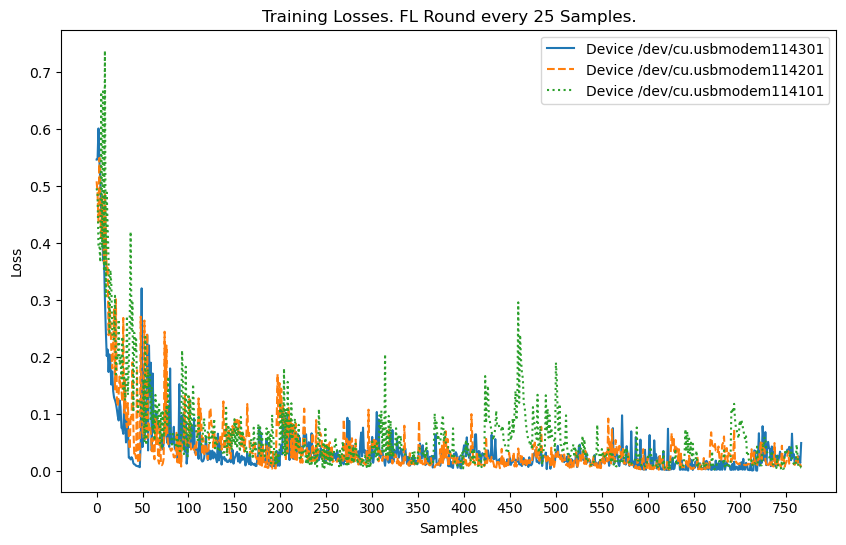

In [38]:
plot(get_info(loaded_dict, 'losses'), samples=768, step=50)

In [25]:
x_losses = []
for i,x in enumerate(df_test_normalized.values):
    dt, res, loss = predict(devices[0],df_test_normalized.values[i], df_test_normalized.values[i])
    x_losses.append(loss)

In [27]:
r = pd.DataFrame(x_losses)
r.columns = ['loss']
y_df = pd.DataFrame(y)
y_anomalies_df = pd.DataFrame(y_anomalies)

ys = pd.concat([y_df, y_anomalies_df])
ys['loss'] = r['loss']

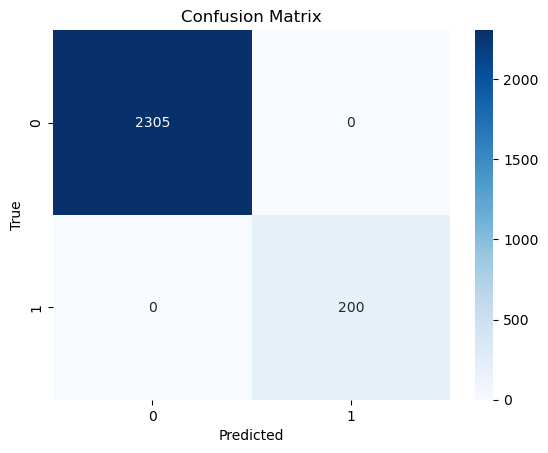

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Set a threshold to classify data as normal or anomalous
threshold = 1.3
y_pred = [1 if error > threshold else 0 for error in r['loss']]
# Compute evaluation metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'ys' is a DataFrame or Series containing the ground truth labels ('anomaly')
# Assuming 'y_pred' is a list, DataFrame, or Series containing the predicted labels

# Calculate evaluation metrics
accuracy = accuracy_score(ys['anomaly'], y_pred)
precision = precision_score(ys['anomaly'], y_pred)
recall = recall_score(ys['anomaly'], y_pred)
f1 = f1_score(ys['anomaly'], y_pred)

# Create a confusion matrix
cm = confusion_matrix(ys['anomaly'], y_pred, labels=[0, 1])

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")